# Advanced Features

In this notebook you will learn about:
- The surface gallery — all available surface types
- Volume estimation via random ray tracing
- Extracting a sub-region into a new model
- Geometry validation and overlap detection
- System configuration

In [1]:
%matplotlib inline
import aleathor as ath
import matplotlib.pyplot as plt

## Surface gallery

AleaTHOR supports all MCNP surface types. Here we show a selection of primitives and macrobodies.

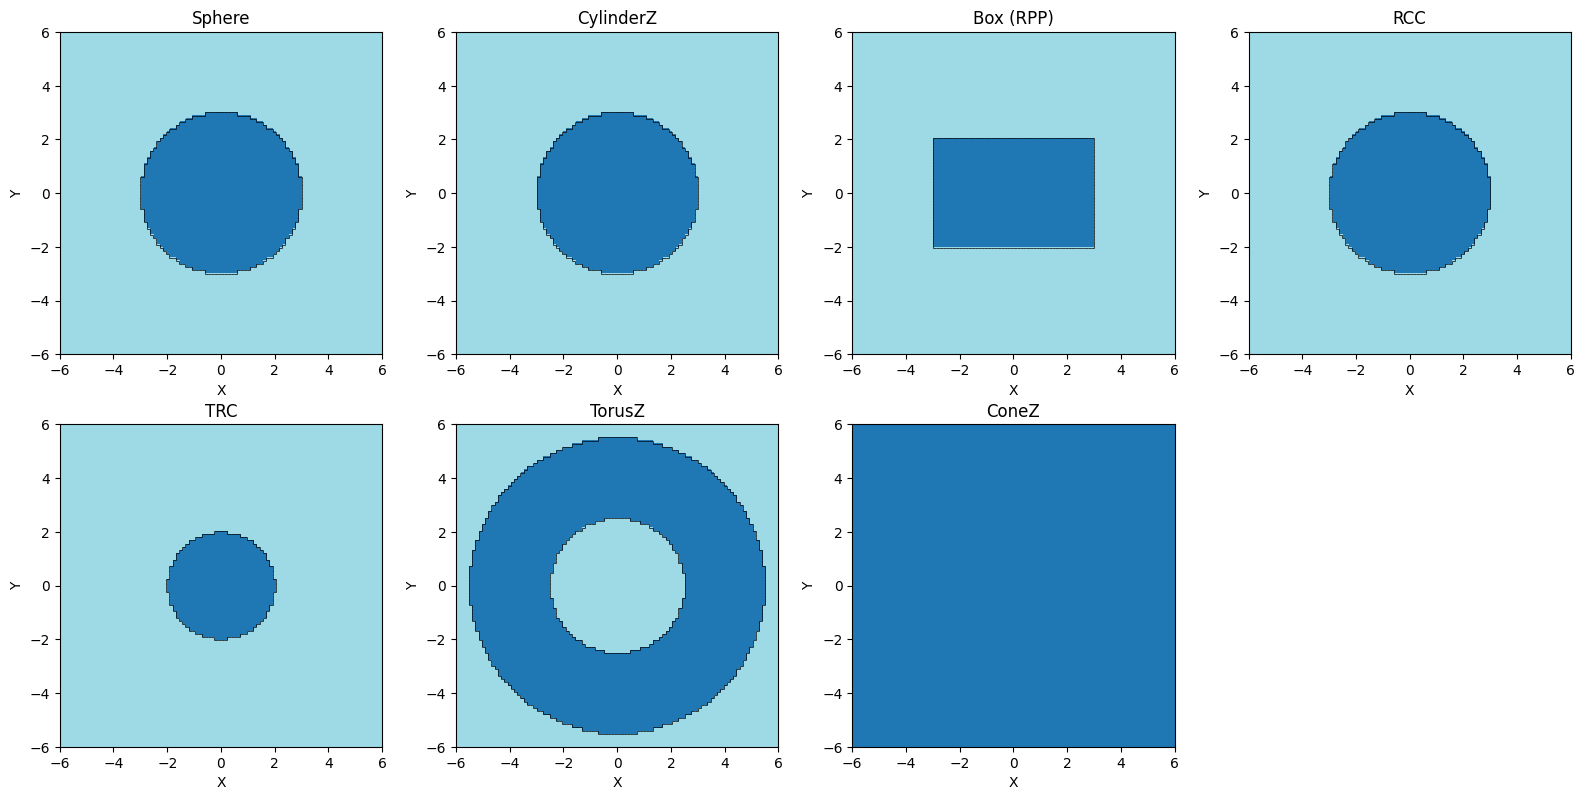

In [2]:
surface_specs = [
    ("Sphere",     ath.Sphere(0, 0, 0, radius=3)),
    ("CylinderZ",  ath.CylinderZ(0, 0, radius=3)),
    ("Box (RPP)",  ath.Box(-3, 3, -2, 2, -4, 4)),
    ("RCC",        ath.RCC(0, 0, -4, 0, 0, 8, 3)),
    ("TRC",        ath.TRC(0, 0, -3, 0, 0, 6, 3, 1)),
    ("TorusZ",     ath.TorusZ(0, 0, 0, major_radius=4, minor_radius=1.5)),
    ("ConeZ",      ath.ConeZ(0, 0, 0, t_sq=0.25)),
]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (label, surf) in enumerate(surface_specs):
    m = ath.Model(label)
    outer = ath.Box(-8, 8, -8, 8, -8, 8)
    m.add_cell(region=-surf, material=1, density=1.0)
    m.add_cell(region=-outer & +surf, material=0, density=0)
    m.plot(z=0, bounds=(-6, 6, -6, 6), ax=axes[idx])
    axes[idx].set_title(label)

# Hide the unused subplot
axes[-1].set_visible(False)
plt.tight_layout()

## Volume estimation

`compute_bounding_sphere()` finds a tight bounding sphere, then `estimate_cell_volumes()` uses random ray tracing inside that sphere to estimate each cell's volume.

In [3]:
model = ath.Model("Volume test")

s = ath.Sphere(0, 0, 0, radius=5)
b = ath.Box(-8, 8, -8, 8, -8, 8)
model.add_cell(region=-s,          material=1, density=10.0, name="sphere")
model.add_cell(region=-b & +s,     material=2, density=1.0,  name="box_shell")

cx, cy, cz, r = model.compute_bounding_sphere()
print(f"Bounding sphere: center=({cx:.1f}, {cy:.1f}, {cz:.1f}), radius={r:.1f}")

volumes = model.estimate_cell_volumes(n_rays=50000)
print(f"\nEstimated volumes (50 000 rays):")
for key, vol in sorted(volumes.items()):
    # Skip metadata keys (e.g. 'rel_errors') — only process numeric cell IDs
    try:
        cid = int(key)
    except (ValueError, TypeError):
        continue
    cell = model[cid]
    print(f"  Cell {cid} ({cell.name:10s}): {vol:8.1f} cm³")

import math
exact_sphere = 4/3 * math.pi * 5**3
print(f"\nExact sphere volume: {exact_sphere:.1f} cm³")

Bounding sphere: center=(0.0, 0.0, 0.0), radius=14.0

Estimated volumes (50 000 rays):

Exact sphere volume: 523.6 cm³


## Extract a sub-region

`extract_region(bounds)` returns a new `Model` containing only the cells whose bounding boxes intersect the given box.

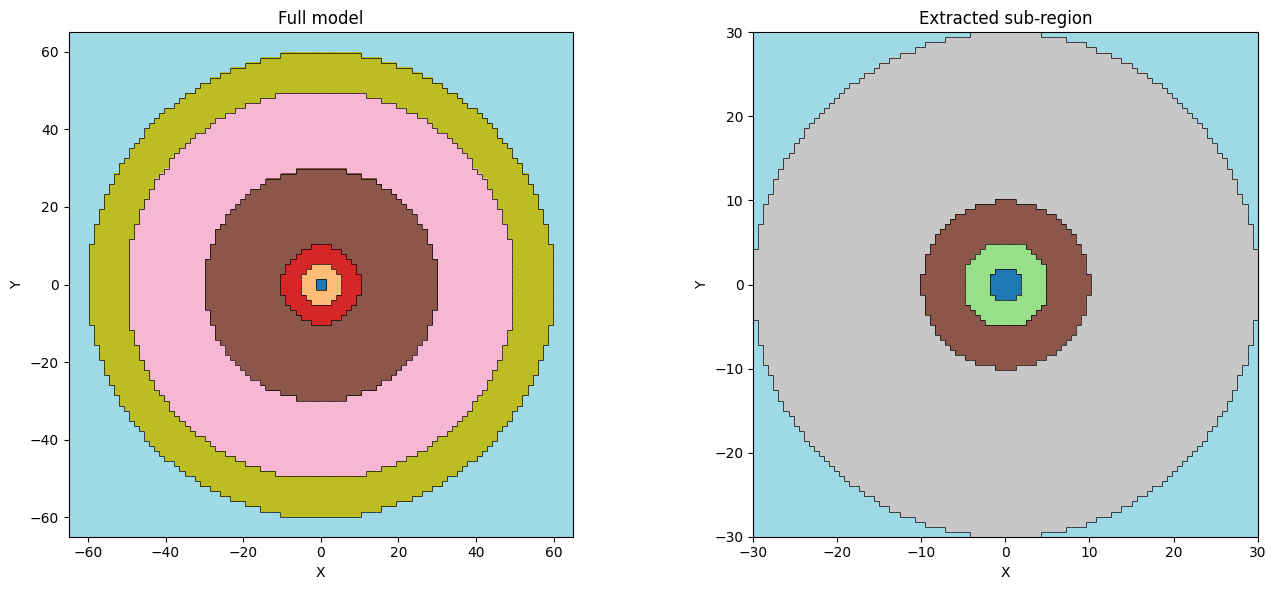

In [4]:
# Load a larger model
full = ath.load("../tests/data/shielding.inp")

# Extract a sub-region
sub = full.extract_region((-30, 30, -30, 30, -5, 5))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
full.plot(z=0, bounds=(-65, 65, -65, 65), ax=ax1)
ax1.set_title("Full model")
sub.plot(z=0, bounds=(-30, 30, -30, 30), ax=ax2)
ax2.set_title("Extracted sub-region")
plt.tight_layout()

Cell(1, material=1, universe=0)

## Validation and overlap detection

In [5]:
issues = full.validate()
if issues:
    for msg in issues:
        print(f"  {msg}")
else:
    print("No issues found.")

overlaps = full.find_overlaps()
print(f"\nOverlapping cell pairs: {len(overlaps)}")
for c1, c2 in overlaps[:5]:  # show first 5
    print(f"  Cell {c1.id} <-> Cell {c2.id}")

  Cell 1 uses undefined material 1
  Cell 2 uses undefined material 2
  Cell 3 uses undefined material 3
  Cell 4 uses undefined material 4
  Cell 5 uses undefined material 5
  Cell 6 uses undefined material 6

Overlapping cell pairs: 0


## Configuration

The C library exposes a configuration dictionary. Useful keys include `log_level`, `abs_tol`, `rel_tol`, `dedup`, and `export_materials`.

In [6]:
model = ath.Model()

# Read current configuration
cfg = model.config
for k, v in sorted(cfg.items()):
    print(f"  {k:25s} = {v}")

  abs_tol                   = 1e-06
  dedup                     = True
  export_materials          = True
  export_transforms         = True
  fill_depth                = 0
  flatten_max_depth         = 0
  log_level                 = 2
  mcnp_cont_indent          = 5
  mcnp_max_col              = 80
  merge_cell_weight         = 1.0
  merge_max_surfaces        = 24
  merge_min_cells           = 1
  merge_surface_weight      = 0.1
  rel_tol                   = 1e-09
  surface_policy            = 0
  transform_mode            = 0
  trcl_mode                 = 0
  universe_depth            = -1
  void_max_depth            = 8
  void_min_size             = 0.1
  void_samples              = 27
  zero_threshold            = 1e-10


In [7]:
# Update configuration — only provided keys are changed
model.config = {'log_level': 3}
print(f"log_level is now: {model.config['log_level']}")

log_level is now: 3
